In [141]:
import string
import json
from argparse import ArgumentParser
from typing import List

import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from chex import Array
from collections import defaultdict

from ml4wifi.envs.sim import DATA_RATES
from ml4wifi.envs.scenarios.static import simple_scenario_5
from ml4wifi.plots.config import AGENT_NAMES
from ml4wifi.plots.utils import confidence_interval

In [142]:
COLORS = pl.cm.viridis(np.linspace(0., 1., 5))
APS_NAMES = string.ascii_uppercase

RESULTS_FILE = "/Users/wciezobka/ncn/mapc-mab/all_results.json"
SCENARIO = simple_scenario_5()
WARMUP = 0

## Loading results

In [143]:
with open(RESULTS_FILE, 'r') as file:
    results = json.load(file)

## Counting actions

In [144]:
# Define frequency dict of actions
actions_dict = defaultdict(lambda: 0)

# Count actions
agent = results[0]["agents"][0]
n_runs = len(agent["actions"])
for run in agent["actions"]:
    for action in run[WARMUP:]:
        # Cast action to immutable type
        action = tuple([tuple(tx) for tx in action])
        actions_dict[action] += 1

# Sort actions by frequency
actions = sorted(actions_dict.items(), key=lambda x: x[1], reverse=True)

# Scale actions by number of runs
actions = [(action, freq / n_runs) for action, freq in actions]

## Agregate actions by tx AP

### Calculating frequency dicts

In [145]:
action_to_names = lambda tx: "".join([APS_NAMES[i] for i, tx in enumerate(tx) if tx])
actions_aps = [(action_to_names(tx), freq) for tx, freq in actions]

# Aggregate actions by tx APs
actions_aps_aggregated = defaultdict(lambda: 0)
for action, freq in actions_aps:
    actions_aps_aggregated[action] += freq

# Re-run sorting
actions_aps_aggregated = sorted(actions_aps_aggregated.items(), key=lambda x: x[1], reverse=True)

### Plottting

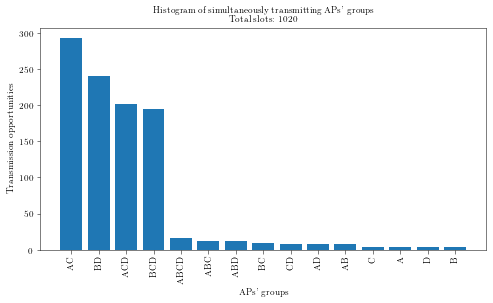

In [146]:
# Plot histogram of actions_aps_aggregated
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([x[0] for x in actions_aps_aggregated], [x[1] for x in actions_aps_aggregated])
ax.set_xlabel("APs' groups")
ax.set_ylabel("Transmission opportunities")
ax.set_title(
    "Histogram of simultaneously transmitting APs' groups" +
    f"\nTotal slots: {len(run[WARMUP:])}"
)
plt.xticks(rotation=90)
plt.savefig("aggregating-by-APs.pdf", bbox_inches='tight')

## Aggregate actions by rx STAs

In [147]:
# Aggregate actions by tx APs
actions_stas_aggregated = defaultdict(lambda: 0)
for action, freq in actions:
    for sta in action:
        if sta:
            actions_stas_aggregated[f"STA_{sta[0]}"] += freq

# Re-run sorting
actions_stas_aggregated = sorted(actions_stas_aggregated.items(), key=lambda x: x[1], reverse=True)

In [148]:
txops_slots = len(run[WARMUP:])
txops_values = [x[1] for x in actions_stas_aggregated]
sta_fairness = np.power(np.sum(txops_values), 2) / (len(txops_values) * np.sum(np.power(txops_values, 2)))
print(f"Jain's fairness index: {sta_fairness}")

Jain's fairness index: 0.8604003260967468


In [149]:
actions_stas_aggregated

[('STA_14', 312.39999999999947),
 ('STA_19', 273.1999999999996),
 ('STA_15', 204.79999999999978),
 ('STA_5', 202.79999999999976),
 ('STA_18', 171.59999999999977),
 ('STA_4', 156.39999999999975),
 ('STA_16', 144.59999999999968),
 ('STA_9', 143.79999999999967),
 ('STA_8', 129.20000000000002),
 ('STA_12', 117.40000000000008),
 ('STA_10', 115.00000000000013),
 ('STA_11', 109.20000000000014),
 ('STA_13', 104.60000000000015),
 ('STA_7', 98.60000000000012),
 ('STA_6', 97.40000000000016),
 ('STA_17', 96.60000000000018)]

### Plotting

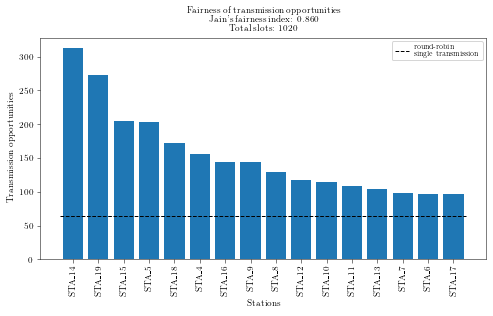

In [150]:
n_stas = len(actions_stas_aggregated)

# Plot histogram of actions_stas_aggregated
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([x[0] for x in actions_stas_aggregated], [x[1] for x in actions_stas_aggregated])
ax.plot([-0.5, n_stas - 0.5], [txops_slots / n_stas] * 2, color="black", linestyle="--", label="round-robin\nsingle transmission")
ax.set_xlabel("Stations")
ax.set_ylabel("Transmission opportunities")
ax.set_title(
    f"Fairness of transmission opportunities" +
    f"\nJain's fairness index: {sta_fairness:.3f}" +
    f"\nTotal slots: {txops_slots}"
)
ax.legend()
plt.xticks(rotation=90)
plt.savefig("aggregating-by-STAs.pdf", bbox_inches='tight')

In [151]:
sum([x[1] for x in actions_stas_aggregated]) / 5 / 1020

0.4858039215686272

## Blob top 10 actions

In [152]:
def plot(scenario, top_actions, filename = None) -> None:
    colors_actions = plt.colormaps['jet'](np.linspace(0, 1, len(top_actions)))
    ap_labels = string.ascii_uppercase

    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)

    # Plot topology
    pos = scenario.pos
    for i, (ap, stations) in enumerate(scenario.associations.items()):
        ax.scatter(pos[ap, 0], pos[ap, 1], marker='x', color="black")
        ax.scatter(pos[stations, 0], pos[stations, 1], marker='.', color="black")
        ax.annotate(f'AP {ap_labels[i]}', (pos[ap, 0], pos[ap, 1] + 2), color="black", va='bottom', ha='center')

        radius = np.max(np.sqrt(np.sum((pos[stations, :] - pos[ap, :]) ** 2, axis=-1)))
        circle = plt.Circle((pos[ap, 0], pos[ap, 1]), radius * 1.2, fill=False, linewidth=0.5)
        ax.add_patch(circle)

    # Plot walls
    if scenario.walls_pos is not None:
        for wall in scenario.walls_pos:
            ax.plot([wall[0], wall[2]], [wall[1], wall[3]], color='black', linewidth=1)
    
    # Plot actions
    max_count = max([x[1] for x in top_actions])
    for i, (action, count) in enumerate(top_actions):
        action = [sta[0] for sta in action if sta]
        for sta in action:
            radius = 50 * (count / max_count)
            ax.scatter(pos[sta, 0], pos[sta, 1], marker='o', color=colors_actions[i], s=radius**2, alpha=0.4, edgecolor='none')
            

    ax.set_axisbelow(True)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_aspect('equal')
    ax.set_title('Location of nodes')
    ax.grid()

    if filename:
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight')
        plt.clf()
    else:
        plt.show()

In [153]:
# Plot the most popular STA groups
plot(SCENARIO, actions[:5], filename="top-4.pdf")

<Figure size 432x432 with 0 Axes>

In [154]:
actions[:10]

[(((6,), (), (15,), ()), 43.6),
 (((), (10,), (), (19,)), 41.6),
 (((5,), (), (15,), ()), 41.4),
 (((7,), (), (15,), ()), 40.8),
 (((4,), (), (15,), ()), 33.2),
 (((), (9,), (14,), (18,)), 26.0),
 (((5,), (), (14,), ()), 24.6),
 (((), (8,), (), (19,)), 23.2),
 (((5,), (), (14,), (19,)), 23.2),
 (((), (8,), (14,), (16,)), 23.0)]